Evaluating strategy: random


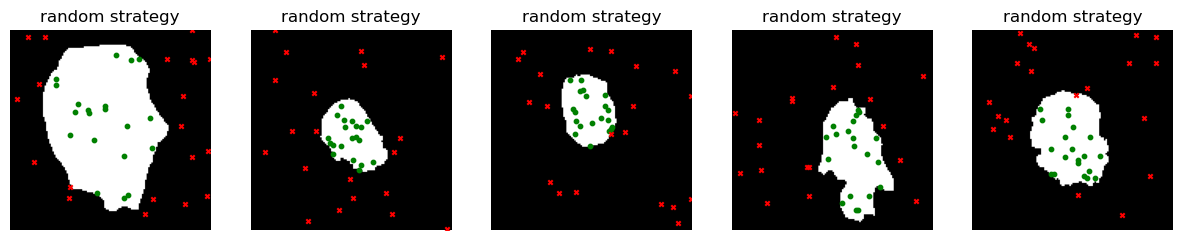

Evaluating strategy: boundary


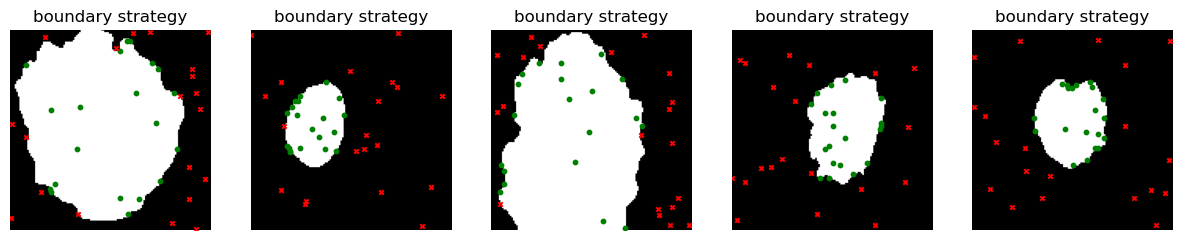

Evaluating strategy: cluster


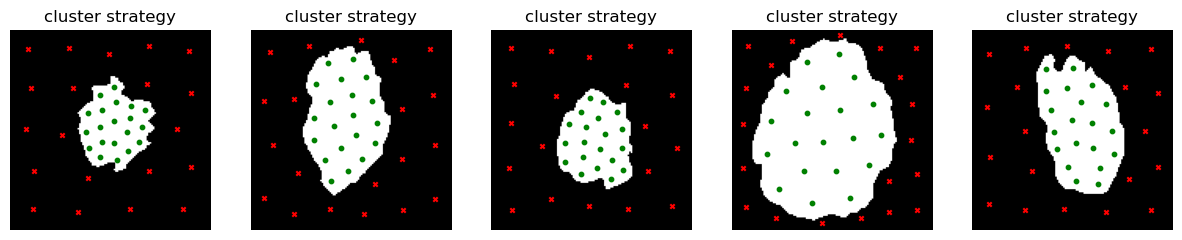

Evaluating strategy: uniform


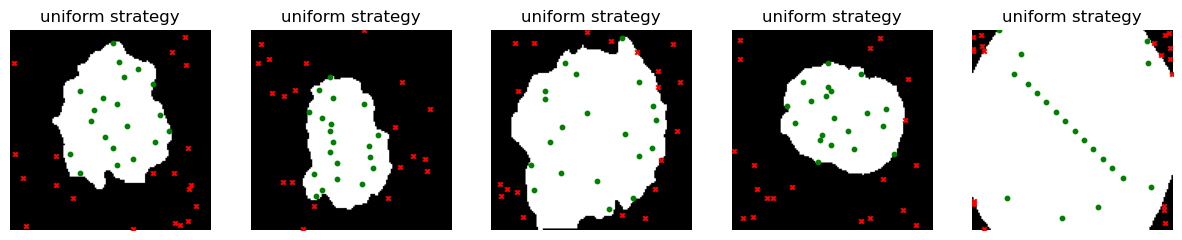

Evaluating strategy: beta


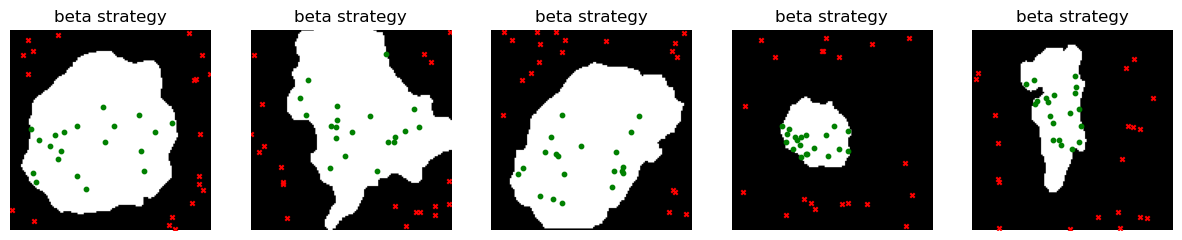

In [1]:
import os
import numpy as np
import random
import PIL.Image as Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import defaultdict
import cv2
import torch.nn as nn
from time import time
import torch.nn.functional as F
import torch.optim as optim



class SkinLesionLoader(Dataset):
    def __init__(self, transform, dataset_path, split='train', strategy='random'):
        'Initialization'
        self.transform = transform  # This transformation is for the input image only.
        self.strategy = strategy  # Sampling strategy
        
        # Collect all image paths and label paths
        self.image_paths = []
        self.label_paths = []

        # Loop through all IMG### folders
        for folder_name in os.listdir(dataset_path):
            folder_path = os.path.join(dataset_path, folder_name)
            if os.path.isdir(folder_path):
                # Add dermoscopic image path
                dermoscopic_image_path = os.path.join(folder_path, f'{folder_name}_Dermoscopic_Image', f'{folder_name}.bmp')
                if os.path.exists(dermoscopic_image_path):
                    self.image_paths.append(dermoscopic_image_path)
                
                # Add lesion image path
                lesion_image_path = os.path.join(folder_path, f'{folder_name}_lesion', f'{folder_name}_lesion.bmp')
                if os.path.exists(lesion_image_path):
                    self.label_paths.append(lesion_image_path)

        # Ensure both lists have the same length
        assert len(self.image_paths) == len(self.label_paths), "Image and label counts do not match."

        # Randomly shuffle the dataset
        combined = list(zip(self.image_paths, self.label_paths))
        random.shuffle(combined)
        self.image_paths, self.label_paths = zip(*combined)

        # Split indices for 70-15-15
        total_len = len(self.image_paths)
        train_split = int(total_len * 0.7)
        val_split = int(total_len * 0.85)  # 70% for training, next 15% for validation

        if split == 'train':
            self.image_paths = self.image_paths[:train_split]
            self.label_paths = self.label_paths[:train_split]
        elif split == 'val':
            self.image_paths = self.image_paths[train_split:val_split]
            self.label_paths = self.label_paths[train_split:val_split]
        elif split == 'test':
            self.image_paths = self.image_paths[val_split:]
            self.label_paths = self.label_paths[val_split:]
        else:
            raise ValueError("Invalid split name. Use 'train', 'val', or 'test'.")

    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        
        image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB format
        label = Image.open(label_path).convert("L")    # Ensure label is in grayscale
        
        # Apply transform only to the image
        X = self.transform(image)
        
        # Convert label to a numpy array (keep original size)
        Y = np.array(label)
        
        # Ensure labels are all of the same size
        Y = Image.fromarray(Y).resize((X.shape[1], X.shape[2]), Image.NEAREST)
        Y = np.array(Y)
        
        # Generate weak annotations (positive and negative clicks)
        pos_points, neg_points = self.generate_click_points(Y)
        
        return X, Y, pos_points, neg_points

    def generate_click_points(self, label_np, num_points=20):
        # Get positive and negative pixels
        positive_pixels = np.argwhere(label_np > 0)  # Lesion region
        negative_pixels = np.argwhere(label_np == 0) # Background region
        
        if self.strategy == 'random':
            return self.random_sampling(positive_pixels, negative_pixels, num_points)
        elif self.strategy == 'boundary':
            return self.boundary_focused_sampling(label_np, positive_pixels, negative_pixels, num_points)
        elif self.strategy == 'cluster':
            return self.cluster_based_sampling(positive_pixels, negative_pixels, num_points)
        elif self.strategy == 'uniform':
            return self.uniform_sampling(positive_pixels, negative_pixels, num_points)
        elif self.strategy == 'beta':
            return self.beta_sampling(positive_pixels, negative_pixels, num_points, alpha=4, beta=3)
        else:
            raise ValueError(f"Invalid strategy name: {self.strategy}")

    def random_sampling(self, positive_pixels, negative_pixels, num_points):
        pos_points = positive_pixels[np.random.choice(len(positive_pixels), num_points, replace=False)]
        neg_points = negative_pixels[np.random.choice(len(negative_pixels), num_points, replace=False)]
        return pos_points, neg_points

    def boundary_focused_sampling(self, label_np, positive_pixels, negative_pixels, num_points):
        # Boundary detection using Canny
        edges = cv2.Canny(label_np, 100, 200)
        boundary_pixels = np.argwhere(edges > 0)
        
        # Sampling from boundary and central lesion area
        boundary_sample_size = min(len(boundary_pixels), num_points // 2)
        central_sample_size = num_points - boundary_sample_size
        boundary_points = boundary_pixels[np.random.choice(len(boundary_pixels), boundary_sample_size, replace=False)]
        central_points = positive_pixels[np.random.choice(len(positive_pixels), central_sample_size, replace=False)]
        return np.vstack([boundary_points, central_points]), negative_pixels[np.random.choice(len(negative_pixels), num_points, replace=False)]

    def cluster_based_sampling(self, positive_pixels, negative_pixels, num_points):
        # Use clustering to find representative points
        kmeans_positive = KMeans(n_clusters=num_points, random_state=42).fit(positive_pixels)
        kmeans_negative = KMeans(n_clusters=num_points, random_state=42).fit(negative_pixels)
        return kmeans_positive.cluster_centers_.astype(int), kmeans_negative.cluster_centers_.astype(int)

    def uniform_sampling(self, positive_pixels, negative_pixels, num_points):
        # Uniform distribution across lesion area
        step_size = max(1, len(positive_pixels) // num_points)
        positive_points = positive_pixels[::step_size][:num_points]
        negative_points = negative_pixels[np.random.choice(len(negative_pixels), num_points, replace=False)]
        return positive_points, negative_points

    def beta_sampling(self, positive_pixels, negative_pixels, num_points, alpha, beta):
        # Beta distribution-based sampling
        lesion_area = positive_pixels.shape[0]
        positive_points = []
        for _ in range(num_points):
            index = int(np.round(np.random.beta(alpha, beta) * (lesion_area - 1)))
            index = np.clip(index, 0, lesion_area - 1)
            positive_points.append(positive_pixels[index])
        positive_points = np.array(positive_points)
        
        # Negative points with distance constraint
        min_distance = 15
        negative_points = []
        for _ in range(num_points):
            neg_point = random.choice(negative_pixels)
            while np.min(np.linalg.norm(positive_pixels - neg_point, axis=1)) < min_distance:
                neg_point = random.choice(negative_pixels)
            negative_points.append(neg_point)
        negative_points = np.array(negative_points)
        
        return positive_points, negative_points


# Usage
data_path = "/dtu/datasets1/02516/PH2_Dataset_images"
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a fixed size
    transforms.ToTensor()           # Convert to tensor
])

strategies = ['random', 'boundary', 'cluster', 'uniform', 'beta']

# Iterate over strategies and evaluate results
for strategy in strategies:
    print(f"Evaluating strategy: {strategy}")
    dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='train', strategy=strategy)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Display sample annotations for visualization
    sampled_indices = random.sample(range(len(dataset)), 5)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sampled_indices):
        image, label, pos_points, neg_points = dataset[idx]
        plt.subplot(1, 5, i + 1)
        plt.imshow(label, cmap='gray')
        plt.scatter(pos_points[:, 1], pos_points[:, 0], c='green', marker='o', s=10)
        plt.scatter(neg_points[:, 1], neg_points[:, 0], c='red', marker='x', s=10)
        plt.title(f"{strategy} strategy")
        plt.axis('off')
    plt.show()


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
class UNet2(nn.Module):
    def __init__(self, parameter_count=100):
        super().__init__()

        def parameters_from_depth(parameters, depth):
            return parameters * 2 * depth

        par0 = parameters_from_depth(parameter_count, 1)
        par1 = parameters_from_depth(parameter_count, 2)
        par2 = parameters_from_depth(parameter_count, 3)
        par3 = parameters_from_depth(parameter_count, 4)
        par4 = parameters_from_depth(parameter_count, 5)

        # encoder (downsampling)
        self.layer0 = nn.Sequential(
            nn.Conv2d(3, par0, 3, padding=1),
            nn.BatchNorm2d(par0),
            nn.ReLU(),
            nn.Conv2d(par0, par0, 3, stride=1, padding=1),
            nn.BatchNorm2d(par0),
            nn.ReLU(),
        )
        self.pool0 = nn.Conv2d(par0, par1, 3, stride=2, padding=1)

        self.layer1 = nn.Sequential(
            nn.Conv2d(par1, par1, 3, padding=1),
            nn.BatchNorm2d(par1),
            nn.ReLU(),
            nn.Conv2d(par1, par1, 3, stride=1, padding=1),
            nn.BatchNorm2d(par1),
            nn.ReLU(),
        )

        self.pool1 = nn.Conv2d(par1, par2, 3, stride=2, padding=1)
        self.layer2 = nn.Sequential(
            nn.Conv2d(par2, par2, 3, padding=1),
            nn.BatchNorm2d(par2),
            nn.ReLU(),
            nn.Conv2d(par2, par2, 3, stride=1, padding=1),
            nn.BatchNorm2d(par2),
            nn.ReLU(),
        )
        self.pool2 = nn.Conv2d(par2, par3, 3, stride=2, padding=1)
        self.layer3 = nn.Sequential(
            nn.Conv2d(par3, par3, 3, padding=1),
            nn.BatchNorm2d(par3),
            nn.ReLU(),
            nn.Conv2d(par3, par3, 3, stride=1, padding=1),
            nn.BatchNorm2d(par3),
            nn.ReLU(),
        )
        self.pool3 = nn.Conv2d(par3, par4, 3, stride=2, padding=1)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(par4, par4, 3, padding=1),
            nn.BatchNorm2d(par4),
            nn.ReLU(),
            nn.Conv2d(par4, par4, 3, padding=1),
            nn.BatchNorm2d(par4),
            nn.ReLU(),
            nn.Conv2d(par4, par4, 3, padding=1),
            nn.BatchNorm2d(par4),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(par4, par3, kernel_size=2, stride=2, padding=0)
        self.dec0 = nn.Sequential(
            nn.Conv2d(par3 * 2, par3, 3, padding=1),
            nn.BatchNorm2d(par3),
            nn.ReLU(),
            nn.Conv2d(par3, par3, 3, padding=1),
            nn.BatchNorm2d(par3),
            nn.ReLU(),
        )

        self.upsample1 = nn.ConvTranspose2d(par3, par2, kernel_size=2, stride=2, padding=0)
        self.dec1 = nn.Sequential(
            nn.Conv2d(par2 * 2, par2, 3, padding=1),
            nn.BatchNorm2d(par2),
            nn.ReLU(),
            nn.Conv2d(par2, par2, 3, padding=1),
            nn.BatchNorm2d(par2),
            nn.ReLU(),
        )
        self.upsample2 = nn.ConvTranspose2d(par2, par1, kernel_size=2, stride=2, padding=0)
        self.dec2 = nn.Sequential(
            nn.Conv2d(par1 * 2, par1, 3, padding=1),
            nn.BatchNorm2d(par1),
            nn.ReLU(),
            nn.Conv2d(par1, par1, 3, padding=1),
            nn.BatchNorm2d(par1),
            nn.ReLU(),
        )
        self.upsample3 = nn.ConvTranspose2d(par1, par0, kernel_size=2, stride=2, padding=0)
        self.dec3 = nn.Sequential(
            nn.Conv2d(par0 * 2, par0, 3, padding=1),
            nn.BatchNorm2d(par0),
            nn.ReLU(),
            nn.Conv2d(par0, par0, 3, padding=1),
            nn.BatchNorm2d(par0),
            nn.ReLU(),
        )
        self.final = nn.Conv2d(par0, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.layer0(x)
        e0 = self.pool0(x1)
        e1 = self.pool1(self.layer1(e0))
        e2 = self.pool2(self.layer2(e1))
        e3 = self.pool3(self.layer3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e2], dim=1)
        d0 = self.dec0(d0)

        d1 = self.upsample1(d0)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e0], dim=1)
        d2 = self.dec2(d2)

        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, x1], dim=1)
        d3 = self.dec3(d3)
        d3 = self.final(d3)
        return d3


In [8]:
def point_level_loss(y_pred, pos_points, neg_points):
    loss = 0
    for i in range(len(pos_points)):
        pos = pos_points[i]
        neg = neg_points[i]
        loss += F.binary_cross_entropy_with_logits(y_pred[:, :, pos[:, 0], pos[:, 1]], torch.ones(pos.shape[0]).to(y_pred.device))
        loss += F.binary_cross_entropy_with_logits(y_pred[:, :, neg[:, 0], neg[:, 1]], torch.zeros(neg.shape[0]).to(y_pred.device))
    return loss / (len(pos_points) * 2)

In [5]:
# Define training function
def train_with_validation(model, opt, epochs, train_loader, val_loader, test_loader, patience=5):
    X_test, Y_test, _, _ = next(iter(test_loader))
    best_val_loss = float('inf')
    patience_counter = 0
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=3, factor=0.5, verbose=True)

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        # Training phase
        avg_train_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch, pos_points, neg_points in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = point_level_loss(Y_pred, pos_points, neg_points)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_train_loss += loss.item() / len(train_loader)

        # Validation phase
        avg_val_loss = 0
        model.eval()  # validation mode
        with torch.no_grad():  # disable gradient computation
            for X_val, Y_val, pos_points, neg_points in val_loader:
                X_val = X_val.to(device)
                Y_val = Y_val.to(device)

                Y_val_pred = model(X_val)
                val_loss = point_level_loss(Y_val_pred, pos_points, neg_points)  # forward-pass
                avg_val_loss += val_loss.item() / len(val_loader)

        toc = time()
        print(f' - train loss: {avg_train_loss:.4f} - val loss: {avg_val_loss:.4f}')

        # Adjust learning rate based on validation loss
        lr_scheduler.step(avg_val_loss)

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}, saving model.")
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save the model checkpoint
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping triggered. Training stopped.")
                break

        # Show intermediate results
        Y_hat = torch.sigmoid(model(X_test.to(device))).detach().cpu()
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
            plt.subplot(3, 6, k+13)
            plt.imshow(Y_test[k, 0].detach().cpu(), cmap='gray')
            plt.title('Ground Truth')
            plt.axis('off')
        plt.suptitle('%d / %d - train loss: %f - val loss: %f' % (epoch+1, epochs, avg_train_loss, avg_val_loss))
        plt.show()

In [9]:
# # Training setup
# data_path = "/dtu/datasets1/02516/PH2_Dataset_images"
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),  # Resize to a fixed size
#     transforms.ToTensor()           # Convert to tensor
# ])

# Create dataset instances for train, validation, and test
train_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='train', strategy='random')
val_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='val', strategy='random')
test_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='test', strategy='random')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Instantiate model, optimizer, and train
model = UNet2().to(device)
optimizer = optim.Adam(model.parameters())
train_with_validation(model, optimizer, epochs=20, train_loader=train_loader, val_loader=val_loader, test_loader=test_loader)

* Epoch 1/20


OutOfMemoryError: CUDA out of memory. Tried to allocate 400.00 MiB. GPU 0 has a total capacity of 39.50 GiB of which 250.25 MiB is free. Process 28900 has 23.63 GiB memory in use. Process 2469768 has 540.00 MiB memory in use. Including non-PyTorch memory, this process has 15.08 GiB memory in use. Of the allocated memory 14.37 GiB is allocated by PyTorch, and 234.44 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)